In [8]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
import numpy as np
import math as m
import vice
import sys
sys.path.append("..")
from src.utils import mu, get_velocity_profile, oh_to_12pluslog, boxcarsmoothtrend
load_style_sheet("papers")
print(sys.version_info)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
outputs = [
    "../outputs/constant/vgas-0",
    "../outputs/constant/vgas-0p5",
    "../outputs/constant/vgas-1",
    "../outputs/constant/vgas-1p5",
    # "../outputs/constant/vgas-3"
]
outputs = [vice.output(name) for name in outputs]

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_93211/1877076656.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


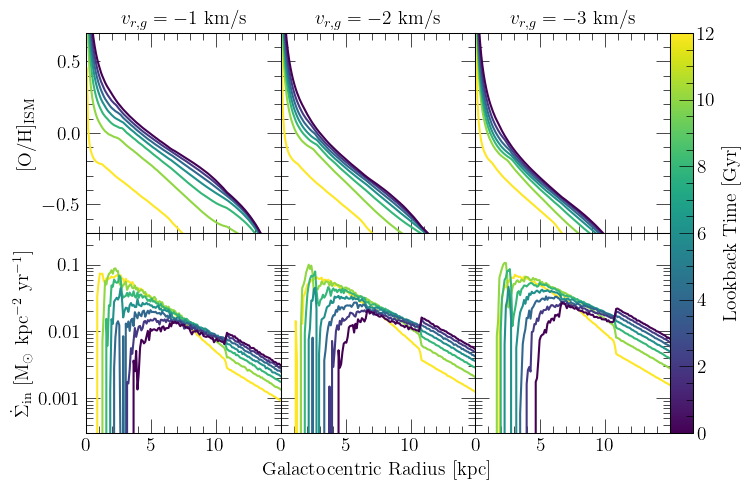

In [14]:
LOOKBACKS = [12, 10, 8, 6, 4, 2, 0]
COLORMAP = "viridis"
TITLES = [r"$v_{r,g} = %d$ km/s" % (_) for _ in [-1, -2, -3]]
SLOPES = [-0.06, -0.12, -0.17]

fig = plt.figure(figsize = (7.5, 5))
top = len(outputs) * [None]
middle = len(outputs) * [None]
bottom = len(outputs) * [None]
for i in range(len(outputs)):
    kwargs = {}
    if i:
        kwargs["sharex"] = top[0]
        kwargs["sharey"] = top[0]
    else: pass
    top[i] = fig.add_subplot(201 + 10 * len(outputs) + i, **kwargs)
    top[i].set_title(TITLES[i])
    plt.setp(top[i].get_xticklabels(), visible = False)
    kwargs["sharex"] = top[0]
    if i:
        plt.setp(top[i].get_yticklabels(), visible = False)
        kwargs["sharey"] = bottom[0]
    bottom[i] = fig.add_subplot(204 + 10 * len(outputs) + i, **kwargs)
    bottom[i].set_yscale("log")
    if i: plt.setp(bottom[i].get_yticklabels(), visible = False)
    top[i].tick_params(zorder = 1000)
    bottom[i].tick_params(zorder = 1000)
top[0].set_ylabel(r"[O/H]$_\text{ISM}$")
bottom[0].set_ylabel(r"$\dot \Sigma_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
top[0].set_ylim([-0.7, 0.7])
top[0].set_xlim([0, 15])
top[0].set_xticks([0, 5, 10])
bottom[0].set_ylim([3.e-4, 0.3])
bottom[0].yaxis.set_major_formatter(fsf("%g"))
bottom[len(outputs) // 2].set_xlabel(r"Galactocentric Radius [kpc]")

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.6])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "vertical")
cbar.set_label("Lookback Time [Gyr]")

def plot_snapshot(ax_z, ax_ifr, output, lookback, zone_width = 0.1, **kwargs):
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    oh = []
    sigma_ifr = []
    for i in range(len(radii)):
        area = np.pi * ((radii[i] + zone_width / 2)**2 - (radii[i] - zone_width / 2)**2)
        zone = output.zones["zone%d" % (i)]
        oh.append(zone.history["[o/h]"][idx])
        sigma_ifr.append(zone.history["ifr"][idx] / area)
    ax_z.plot(radii, oh, **kwargs)
    ax_ifr.plot(radii, sigma_ifr, **kwargs)

for i in range(len(outputs)):
    for j in range(len(LOOKBACKS)):
        kwargs = {"c": cmap.to_rgba(LOOKBACKS[j])}
        plot_snapshot(top[i], bottom[i], outputs[i], LOOKBACKS[j], **kwargs)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0, right = 0.9)
cbar_ax.set_position([
    bottom[-1].get_position().x1,
    bottom[-1].get_position().y0,
    0.03,
    top[-1].get_position().y1 - bottom[-1].get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./constant/metal-inflow-profiles-const.%s" % (ext), **kwargs)
plt.show()

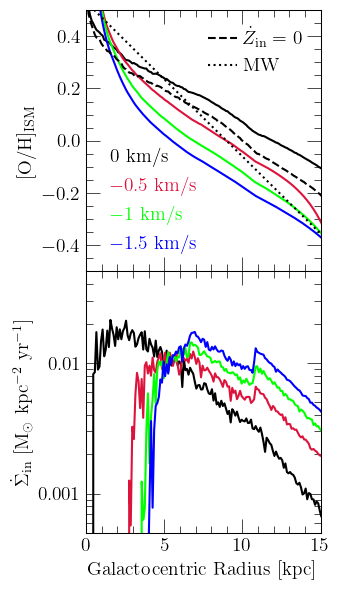

In [10]:
# VELOCITIES = [0, -1, -2, -3]
VELOCITIES = [0, -0.5, -1, -1.5]
COLORS = ["black", "crimson", "lime", "blue"]

fig = plt.figure(figsize = (3.5, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)
ax2.set_yscale("log")
ax2.yaxis.set_major_formatter(fsf("%g"))
ax1.set_xlim([0, 15])
ax2.set_xlabel(r"Galactocentric Radius [kpc]")
plt.setp(ax1.get_xticklabels(), visible = False)
ax1.set_ylabel(r"[O/H]$_\text{ISM}$")
ax2.set_ylabel(r"$\dot \Sigma_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax1.set_ylim([-0.5, 0.5])
# ax1.set_ylim([-0.7, 0.7])
# ax1.set_yticks([-0.5, 0, 0.5])
ax2.set_ylim([5.e-4, 0.05])

line1 = ax1.plot([1, 2], [1, 2], c = named_colors()["black"], linestyle = "--", label = r"$\dot Z_\text{in} = 0$")[0]
line2 = ax1.plot([1, 2], [1, 2], c = named_colors()["black"], linestyle = ":", label = "MW")[0]
kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 1.5
}
leg = ax1.legend(**kwargs)
ax1.add_artist(leg)
line1.remove()
line2.remove()

def plot_output(ax_z, ax_ifr, output, zone_width = 0.1, plot_ifr = True, **kwargs):
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    oh = []
    sigma_ifr = []
    for i in range(len(radii)):
        area = np.pi * ((radii[i] + zone_width / 2)**2 - (radii[i] - zone_width / 2)**2)
        zone = output.zones["zone%d" % (i)]
        oh.append(zone.history["[o/h]"][-1])
        sigma_ifr.append(zone.history["ifr"][-1] / area)
    ax_z.plot(radii, oh, **kwargs)
    if plot_ifr: ax_ifr.plot(radii, sigma_ifr, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"$%g$ km/s" % (VELOCITIES[i])
    }
    # if VELOCITIES[i]:
    #     kwargs["label"] = r"$%g$ km/s" % (VELOCITIES[i])
    # else:
    #     kwargs["label"] = r"$v_{r,g} = 0$"
    plot_output(ax1, ax2, outputs[i], **kwargs)

xvals = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
yvals = [np.log10(vice.solar_z.epsilon_to_z_conversion(9.22, 15.999) / vice.solar_z['o']) - 0.059 * r for r in xvals]
ax1.plot(xvals, yvals, c = named_colors()["black"], linestyle = ":")

zerometinfall = vice.output("../outputs/constant/vgas-0-zerometinfall")
plot_output(ax1, ax2, zerometinfall, plot_ifr = False, c = named_colors()["black"], linestyle = "--")

kwargs = {
    "loc": mpl_loc("lower left"),
    "ncol": 1,
    "handlelength": 0
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./constant/presentday-profiles-const.%s" % (ext), **kwargs)
plt.show()

In [11]:
def boxcarsmoothtrend(xvals, yvals, window = 5):
    smoothed = len(xvals) * [0.]
    for i in range(len(xvals)):
        start = max(0, i - window)
        stop = min(i, len(xvals) - 1)
        smoothed[i] = np.mean(yvals[start:stop])
    return smoothed

/Users/jamesjohnson/anaconda3/envs/python3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jamesjohnson/anaconda3/envs/python3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


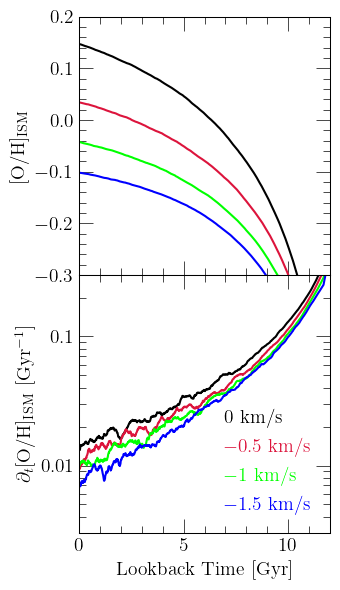

In [12]:
VELOCITIES = [0, -0.5, -1, -1.5]
COLORS = ["black", "crimson", "lime", "blue"]

fig = plt.figure(figsize = (3.5, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)
ax2.set_yscale("log")
plt.setp(ax1.get_xticklabels(), visible = False)
ax2.set_xlabel("Lookback Time [Gyr]")
ax1.set_ylabel(r"[O/H]$_\text{ISM}$")
ax2.set_ylabel(r"$\partial_t$[O/H]$_\text{ISM}$ [Gyr$^{-1}$]")
ax1.set_xlim([0, 12])
ax1.set_ylim([-0.3, 0.2])
ax2.set_ylim([0.003, 0.3])
ax2.yaxis.set_major_formatter(fsf("%g"))

def plot_model(ax_oh, ax_deriv, output, radius = 8, zone_width = 0.1, **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    ax_oh.plot(zone.history["lookback"], zone.history["[o/h]"], **kwargs)
    dt = zone.history["lookback"][-1] - zone.history["lookback"][-2]
    dohdt = [(a - b) / dt for a, b in zip(zone.history["[o/h]"][:-1], zone.history["[o/h]"][1:])]
    dohdt = boxcarsmoothtrend(zone.history["lookback"][:-1], dohdt, window = 50)
    ax_deriv.plot(zone.history["lookback"][:-1], dohdt, **kwargs)

for i in range(len(VELOCITIES)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"$%g$ km/s" % (VELOCITIES[i])
    }
    plot_model(ax1, ax2, outputs[i], **kwargs)

kwargs = {
    "loc": mpl_loc("lower right"),
    "ncol": 1,
    "handlelength": 1
}
leg = ax2.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./constant/solar-annulus-evol-const.%s" % (ext), **kwargs)
plt.show()

In [4]:
def mendezdelgado2022_profile():
    radii = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
#     oh = [np.log10(vice.solar_z.epsilon_to_z_conversion(9.22, 15.999) /
#                    vice.solar_z['o']) - 0.059 * r for r in radii]
    log_oh_plus12 = [9.22 - 0.059 * r for r in radii]
    return [radii, log_oh_plus12]

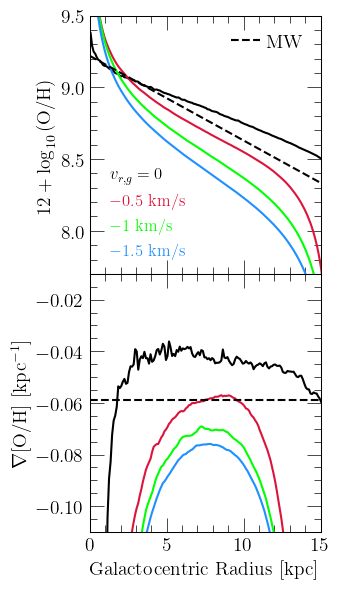

In [11]:
COLORS = ["black", "crimson", "lime", "dodgerblue"]
# LABELS = [r"$\dot L_\text{dyn} / L = %g$ Gyr$^{-1}$" % (_) for _ in [0, -0.05, -0.1, -0.15]]
# LABELS = [r"$%g$ Gyr$^{-1}$" % (_) for _ in [0, -0.02, -0.05, -0.08]]
# LABELS = [r"$\gamma = %g$" % (_) for _ in [0, 0.15, 0.2, 0.25]]
LABELS = [r"$v_{r,g} = 0$", r"$-0.5$ km/s", r"$-1$ km/s", r"$-1.5$ km/s"]

fig = plt.figure(figsize = (3.5, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)
plt.setp(ax1.get_xticklabels(), visible = False)
ax2.set_xlabel(r"Galactocentric Radius [kpc]")
ax1.set_ylabel(r"$12 + \log_{10}\text{(O/H)}$")
# ax1.set_ylabel(r"[O/H]$_\text{ISM}$")
ax2.set_ylabel(r"$\nabla$[O/H] [kpc$^{-1}$]")
ax1.set_xlim([0, 15])
# ax1.set_ylim([-0.7, 0.7])
ax1.set_ylim([7.7, 9.5])
ax2.set_ylim([-0.11, -0.01])
# ax1.set_yticks([-0.5, 0, 0.5])
ax2.set_yticks([-0.1, -0.08, -0.06, -0.04, -0.02])

kwargs = {
    "c": named_colors()["black"],
    "linestyle": "--",
    "zorder": 1000,
    "label": "MW"
}
radii, logohplus12 = mendezdelgado2022_profile()
line1 = ax1.plot(radii, logohplus12, **kwargs)[0]
line2 = ax2.axhline(-0.059, **kwargs)
kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 1.5
}
leg = ax1.legend(**kwargs)
ax1.add_artist(leg)
line1.set_label(None)
line2.set_label(None)

def plot_prediction(output, zone_width = 0.1, **kwargs):
#     radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    radii = [zone_width * (i + 0.5) for i in range(int(15.5 / zone_width))]
    oh = []
    dohdr = []
    for i in range(len(radii)):
        oh.append(output.zones["zone%d" % (i)].history["[o/h]"][-1])
    oh = [oh_to_12pluslog(_) for _ in oh]
    for i in range(len(radii) - 1):
        dohdr.append((oh[i + 1] - oh[i]) / (radii[i + 1] - radii[i]))
    ax1.plot(radii, oh, **kwargs)
    dohdr = boxcarsmoothtrend(radii[:-1], dohdr, window = 10)
    ax2.plot(radii[:-1], dohdr, **kwargs)

# plot_prediction(output, c = named_colors()["black"])
for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i]
    }
    plot_prediction(outputs[i], **kwargs)
    
kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
    "fontsize": 12
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./constant/presentday-oh-profiles-gradients.%s" % (ext), **kwargs)
plt.show()